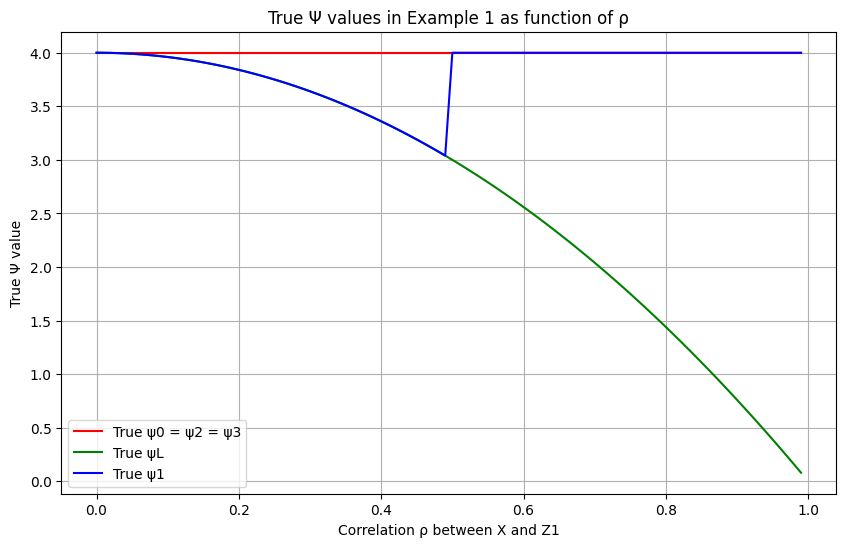

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def true_psi_l_example1(rho):
    return 4.0 * (1 - rho**2)

def true_psi_1_example1(rho):
    if abs(rho) < 0.5:
        return true_psi_l_example1(rho)
    else:
        return TRUE_PSI_0 
        
TRUE_PSI_0 = 4.0

rho_plot_values = np.linspace(0, 0.99, 100)
true_psi_0_plot = np.full_like(rho_plot_values, TRUE_PSI_0)
true_psi_l_plot = true_psi_l_example1(rho_plot_values)
true_psi_1_plot = np.array([true_psi_1_example1(r) for r in rho_plot_values]) # Need to handle scalar vs array input

plt.figure(figsize=(10, 6))
plt.plot(rho_plot_values, true_psi_0_plot, label='True ψ0 = ψ2 = ψ3', color='red')
plt.plot(rho_plot_values, true_psi_l_plot, label='True ψL', color='green')
plt.plot(rho_plot_values, true_psi_1_plot, label='True ψ1', color='blue')
plt.xlabel('Correlation ρ between X and Z1')
plt.ylabel('True Ψ value')
plt.title('True Ψ values in Example 1 as function of ρ')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from sklearn.linear_model import LinearRegression
import numpy.linalg as la
import pandas as pd
from scipy.spatial.distance import cdist 
import scipy.linalg as sla 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold


def generate_data_example1(n, rho, sigma_epsilon=1.0, sigma_xi=1.0):
    """
    Generates data for Example 1 with a given sample size and correlation.
    Y = 2*X + epsilon
    Z1 = delta*X + xi, where delta relates to rho
    Z2, ..., Z5 ~ N(0, 1)
    Correlation(X, Z1) approx rho
    Note: In this example, X is 1D (g=1). Z is 5D (h=5).
    """
    X = np.random.randn(n, 1) 

    if abs(rho) >= 1:
        raise ValueError("Correlation rho must be between -1 and 1")
    if rho == 0:
        delta = 0
    else:
        delta = rho * sigma_xi / np.sqrt(1 - rho**2)

    xi = np.random.randn(n, 1) * sigma_xi
    Z1 = delta * X + xi

    Z_other = np.random.randn(n, 4)
    Z = np.c_[Z1, Z_other]

    epsilon = np.random.randn(n, 1) * sigma_epsilon
    Y = 2 * X + epsilon

    return Y, X, Z

def t_cross_confidence_interval(Y, X, Z, estimate_psi_on_fold_callback, B=5, c_squared=None, alpha=0.05):
    """
    Constructs a confidence interval using the t-Cross method.

    Args:
        Y (np.ndarray): The target variable (shape: n, 1).
        X (np.ndarray): The covariates for which importance is assessed (shape: n, g).
        Z (np.ndarray): The other covariates (shape: n, h).
        estimate_psi_on_fold_callback (function): A function that takes
            (Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n) as input,
            estimates nuisance functions on (Y_train, X_train, Z_train) using train_index,
            and returns the estimated psi value calculated on (Y_test, X_test, Z_test) using test_index.
            Signature: estimate_psi_on_fold_callback(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n) -> float
        B (int): The number of folds for cross-fitting.
        c_squared (float, optional): The square of the constant 'c' for standard error
                                     adjustment (c^2/n). If None, use Var(Y) from the full sample.
        alpha (float): The significance level (1 - confidence level).

    Returns:
        tuple: A tuple containing:
            - psi_mean (float): The mean of the fold-specific psi estimates (overline{psi}).
            - ci_lower (float): The lower bound of the confidence interval.
            - ci_upper (float): The upper bound of the confidence interval.
            - s_squared (float): The sample variance of the valid fold-specific psi estimates.
            - se (float): The corrected standard error used for the CI.
    """
    n = len(Y)
    if n != len(X) or n != len(Z):
        raise ValueError("Y, X, and Z must have the same number of samples.")

    if Y.ndim == 1: Y = Y.reshape(-1, 1)
    if X.ndim == 1: X = X.reshape(-1, 1)
    if Z.ndim == 1: Z = Z.reshape(-1, 1)

    if c_squared is None:
        c_squared = np.var(Y.flatten())**2

    kf = KFold(n_splits=B, shuffle=True, random_state=42)

    psi_estimates_folds = []
    valid_folds_count = 0

    for fold_idx, (train_index, test_index) in enumerate(kf.split(np.arange(n))):
        Y_train, Y_test = Y[train_index], Y[test_index]
        X_train, X_test = X[train_index], X[test_index]
        Z_train, Z_test = Z[train_index], Z[test_index]

        try:
            psi_j = estimate_psi_on_fold_callback(Y_train, X_train, Z_train, Y_test, X_test, Z_test,
                                                train_index, test_index, n)
            if np.isnan(psi_j):
                 continue
            psi_estimates_folds.append(psi_j)
            valid_folds_count += 1
        except Exception as e:
            print(f"Error estimating psi for fold {fold_idx}: {e}")
            print("Skipping fold.")
            continue

    psi_estimates_folds = np.array(psi_estimates_folds)

    if valid_folds_count < 2:
         return np.nan, np.nan, np.nan, np.nan, np.nan

    psi_mean = np.mean(psi_estimates_folds)
    s_squared = np.var(psi_estimates_folds, ddof=1)

    se_squared = s_squared / B + c_squared / n
    se = np.sqrt(se_squared)

    df = valid_folds_count - 1
    if se == 0 or df <= 0:
         return psi_mean, psi_mean, psi_mean, s_squared, se

    t_quantile = t.ppf(1 - alpha/2, df=df)

    ci_lower = psi_mean - t_quantile * se
    ci_upper = psi_mean + t_quantile * se

    return psi_mean, ci_lower, ci_upper, s_squared, se


In [2]:
# def estimate_psi0_nonparam(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n,
#                              kde_bandwidth='silverman', n_samples_monte_carlo=1000):
#     """
#     Estimates the nonparametric psi_0 parameter on test data after training
#     nonparametric models (mu(x,z) and densities) on train data.

#     Uses RandomForestRegressor for mu(x,z) and KernelDensity for densities,
#     with Monte Carlo integration via sampling.

#     Args:
#         Y_train, X_train, Z_train: Training data.
#         Y_test, X_test, Z_test: Test data.
#         train_index, test_index: Indices for train and test splits (not directly used here).
#         n: Total number of samples (not directly used here).
#         kde_bandwidth: Bandwidth for KernelDensity. Can be a float or a string
#                        like 'silverman' or 'scott' (requires fitting KDE first).
#         n_samples_monte_carlo: Number of samples to use for Monte Carlo integration.

#     Returns:
#         Estimated psi_0 value, or np.nan if estimation fails.
#     """
#     # Ensure inputs are numpy arrays and handle 1D cases for X and Z
#     X_train = np.asarray(X_train)
#     X_test = np.asarray(X_test)
#     Z_train = np.asarray(Z_train)
#     Z_test = np.asarray(Z_test)
#     Y_train = np.asarray(Y_train)
#     Y_test = np.asarray(Y_test)

#     if X_train.ndim == 1:
#         X_train = X_train.reshape(-1, 1)
#     if X_test.ndim == 1:
#         X_test = X_test.reshape(-1, 1)
#     if Z_train.ndim == 1:
#         Z_train = Z_train.reshape(-1, 1)
#     if Z_test.ndim == 1:
#         Z_test = Z_test.reshape(-1, 1)
#     if Y_train.ndim > 1:
#         Y_train = Y_train.flatten()
#     if Y_test.ndim > 1:
#         Y_test = Y_test.flatten()


#     num_test_samples = X_test.shape[0]
#     g_dim = X_train.shape[1]
#     h_dim = Z_train.shape[1]

#     # Combine X and Z for mu(x,z) estimation
#     XZ_train = np.hstack((X_train, Z_train))
#     XZ_test = np.hstack((X_test, Z_test))

#     # 1. Estimate mu(x,z) nonparametrically (using RandomForestRegressor)
#     # Using default parameters for simplicity; tuning is often needed.
#     mu_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
#     mu_regressor.fit(XZ_train, Y_train)

#     # 2. Estimate densities p(x), p(z), p(x,z) using KernelDensity
#     # Note: Bandwidth selection is crucial and complex in practice.
#     # Using a simple string option here, but cross-validation is better.
#     try:
#         # For KDE, need to handle case where n_samples < n_features + 1
#         # or if bandwidth estimation methods like 'scott' / 'silverman' require certain conditions
#         if X_train.shape[0] <= g_dim:
#              print("Warning: Not enough train samples for p(x) KDE.")
#              return np.nan
#         px_kde = KernelDensity(bandwidth=kde_bandwidth)
#         px_kde.fit(X_train)

#         if Z_train.shape[0] <= h_dim:
#              print("Warning: Not enough train samples for p(z) KDE.")
#              return np.nan
#         pz_kde = KernelDensity(bandwidth=kde_bandwidth)
#         pz_kde.fit(Z_train)

#         if XZ_train.shape[0] <= g_dim + h_dim:
#              print("Warning: Not enough train samples for p(x,z) KDE.")
#              return np.nan
#         pxz_kde = KernelDensity(bandwidth=kde_bandwidth)
#         pxz_kde.fit(XZ_train)

#     except ValueError as e:
#         print(f"Error fitting KDE: {e}")
#         return np.nan
#     except Exception as e:
#          print(f"An unexpected error occurred during KDE fitting: {e}")
#          return np.nan

#     # 3. Generate samples from densities for Monte Carlo integration
#     try:
#         X_samples_1 = px_kde.sample(n_samples_monte_carlo, random_state=42)
#         X_samples_2 = px_kde.sample(n_samples_monte_carlo, random_state=43) # For mu_0 inside first integral
#         X_samples_3 = px_kde.sample(n_samples_monte_carlo, random_state=44) # For mu_0 inside second integral

#         Z_samples = pz_kde.sample(n_samples_monte_carlo, random_state=42)
#     except Exception as e:
#          print(f"Error sampling from KDE: {e}")
#          return np.nan


#     # 4. Calculate psi_0 hat using the formula from Section 3.2
#     sum_of_L_terms = 0
#     for i in range(num_test_samples):
#         X_i = X_test[i, :].reshape(1, -1) # Keep as 2D for predict
#         Z_i = Z_test[i, :].reshape(1, -1) # Keep as 2D for predict
#         XZ_i = XZ_test[i, :].reshape(1, -1)
#         Y_i = Y_test[i]

#         try:
#             # Term 1: Integral w.r.t p(x)
#             # Estimate mu_0(Z_i) first
#             mu_0_Zi_samples = mu_regressor.predict(np.hstack((X_samples_2, np.tile(Z_i, (n_samples_monte_carlo, 1)))))
#             mu_0_Zi_hat = np.mean(mu_0_Zi_samples)

#             integral_px_samples = mu_regressor.predict(np.hstack((X_samples_1, np.tile(Z_i, (n_samples_monte_carlo, 1)))))
#             integral_px_term = np.mean((integral_px_samples - mu_0_Zi_hat)**2)


#             # Term 2: Integral w.r.t p(z)
#             integral_pz_terms = []
#             for j in range(n_samples_monte_carlo):
#                  Z_j_star = Z_samples[j, :].reshape(1, -1)

#                  # Estimate mu_0(Z_j_star)
#                  mu_0_Zj_star_samples = mu_regressor.predict(np.hstack((X_samples_3, np.tile(Z_j_star, (n_samples_monte_carlo, 1)))))
#                  mu_0_Zj_star_hat = np.mean(mu_0_Zj_star_samples)

#                  mu_at_Xi_Zj_star = mu_regressor.predict(np.hstack((X_i, Z_j_star)))[0]
#                  integral_pz_terms.append((mu_at_Xi_Zj_star - mu_0_Zj_star_hat)**2)
#             integral_pz_term = np.mean(integral_pz_terms)


#             # Term 3: Likelihood ratio term
#             mu_Xi_Zi_hat = mu_regressor.predict(XZ_i)[0]

#             # Calculate densities at the point (X_i, Z_i)
#             log_pxi = px_kde.score_samples(X_i)
#             log_pzi = pz_kde.score_samples(Z_i)
#             log_pxzi = pxz_kde.score_samples(XZ_i)

#             # Convert log-likelihood to likelihood
#             pxi = np.exp(log_pxi)[0]
#             pzi = np.exp(log_pzi)[0]
#             pxzi = np.exp(log_pxzi)[0]

#             # Handle potential division by zero or near-zero density in the denominator
#             # This is where the "overlap problem" manifests.
#             likelihood_ratio_term = 0
#             if pxzi > 1e-9: # Use a small epsilon to avoid division by zero
#                  likelihood_ratio = (pxi * pzi) / pxzi
#                  likelihood_ratio_term = 2 * likelihood_ratio * (mu_Xi_Zi_hat - mu_0_Zi_hat) * (Y_i - mu_Xi_Zi_hat)
#             else:
#                  # If pxzi is effectively zero, the likelihood ratio is infinite/undefined.
#                  # This point (X_i, Z_i) is in a region with no observed data given its XZ combination.
#                  # As the paper mentions, this term can cause problems.
#                  # Returning NaN for the fold might be appropriate, or a warning.
#                  # For now, let's print a warning and treat the term as 0,
#                  # although this is an approximation and might lead to bias.
#                  # print(f"Warning: pxz_kde density close to zero at test point {i}. Likelihood ratio term set to 0.")
#                  pass # likelihood_ratio_term is already 0

#             # Sum up the terms for L(U_i)
#             L_i = integral_px_term + integral_pz_term + likelihood_ratio_term

#             sum_of_L_terms += L_i

#         except Exception as e:
#             # print(f"Error calculating terms for test sample {i}: {e}")
#             return np.nan # Return NaN if any step fails for a sample


#     # Final estimate: Average L(U_i) over test samples and divide by 2
#     psi_0_hat = sum_of_L_terms / (2 * num_test_samples)

#     return psi_0_hat
    
# def is_fit_successful(model):
#     """
#     Simple helper to check if linear regression fitting was likely successful.
#     More robust checks might be needed in a real application.
#     """
#     # Check if coefficients were assigned (a basic indicator of successful fit)
#     return hasattr(model, 'coef_') and model.coef_ is not None



Starting full simulation for Linear Nuisance estimation...

--- Running simulations for rho = 0.00 ---
  Estimating psi_L...


  Coverage rate for rho = 0.00 using psi_L: 1.0000 (based on 50/50 valid runs)
  Estimating psi_0...
  Coverage rate for rho = 0.00 using psi_0: 0.2000 (based on 50/50 valid runs)
  Estimating psi_1...
  Coverage rate for rho = 0.00 using psi_1: 1.0000 (based on 50/50 valid runs)
  Estimating psi_2...
  Coverage rate for rho = 0.00 using psi_2: 1.0000 (based on 50/50 valid runs)
  Estimating psi_3...
  Coverage rate for rho = 0.00 using psi_3: 1.0000 (based on 50/50 valid runs)

--- Running simulations for rho = 0.11 ---
  Estimating psi_L...
  Coverage rate for rho = 0.11 using psi_L: 0.9800 (based on 50/50 valid runs)
  Estimating psi_0...
  Coverage rate for rho = 0.11 using psi_0: 0.1400 (based on 50/50 valid runs)
  Estimating psi_1...
  Coverage rate for rho = 0.11 using psi_1: 1.0000 (based on 50/50 valid runs)
  Estimating psi_2...
  Coverage rate for rho = 0.11 using psi_2: 1.0000 (based on 50/50 valid runs)
  Estimating psi_3...
  Coverage rate for rho = 0.11 using psi_3: 1.0

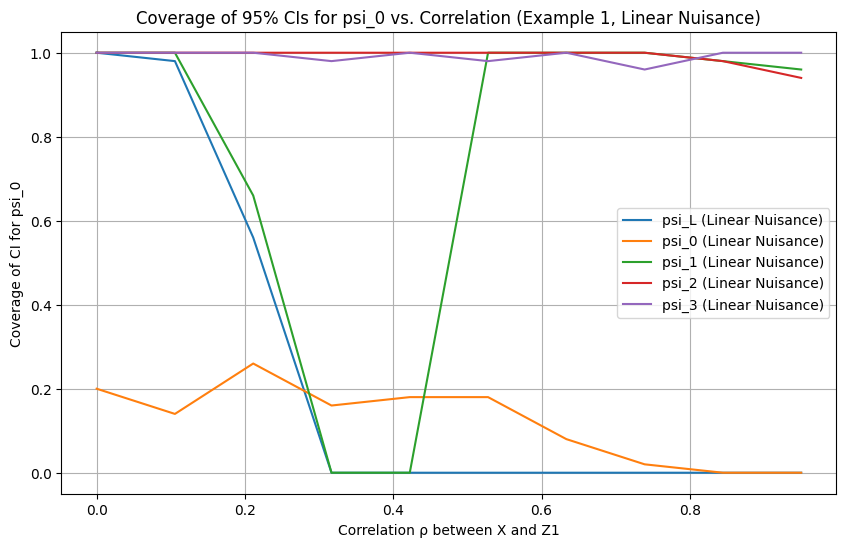

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from scipy.stats import t
from sklearn.linear_model import LinearRegression
import numpy.linalg as la
import pandas as pd

 # Useful for correlation and data handling
# For nonparametric estimation, might need density estimation
# try:
#     from sklearn.neighbors import KernelDensity # Example density estimator
# except ImportError:
#     KernelDensity = None

# Need pygam for Additive Model nuisance estimation
try:
    from pygam import LinearGAM, s
except ImportError:
    LinearGAM, s = None, None # Define them as None if pygam is not installed
    # print("Warning: pygam library not found. Additive Nuisance estimation will be skipped.")

# --- Helper function to check if a Linear Regression fit was successful ---
def is_fit_successful(model):
     # Check if coefficients were assigned (basic check)
     return hasattr(model, 'coef_') and model.coef_ is not None and np.all(np.isfinite(model.coef_))


def estimate_psiL_linear_nuisance(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n):
    """
    Estimates psi_L using Linear Regression for nuisance functions mu(Z) and mu(X,Z).
    psi_L = E[(mu(Z) - mu(X,Z))^2]
    """
    # Nuisance 1: Estimate mu(Z) = E[Y|Z] using Linear Regression Y ~ Z on train data
    mu_Z_model = LinearRegression()
    mu_Z_model.fit(Z_train, Y_train)

    if not is_fit_successful(mu_Z_model): return np.nan

    # Nuisance 2: Estimate mu(X,Z) = E[Y|X,Z] using Linear Regression Y ~ [X, Z] on train data
    XZ_train = np.c_[X_train, Z_train]
    mu_XZ_model = LinearRegression()
    mu_XZ_model.fit(XZ_train, Y_train)

    if not is_fit_successful(mu_XZ_model): return np.nan

    # Predict mu(Z) and mu(X,Z) for test Z and [X, Z]
    mu_hat_Z_test = mu_Z_model.predict(Z_test)
    XZ_test = np.c_[X_test, Z_test]
    mu_hat_XZ_test = mu_XZ_model.predict(XZ_test)

    # Estimate psi_L on the test data using the predictions
    # Use mean of squared differences as an estimator for E[...]
    psi_L_hat = np.mean((mu_hat_Z_test - mu_hat_XZ_test)**2)

    return psi_L_hat

def estimate_psi0_linear_nuisance(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n_total,
                                  n_sim_integral=100, kde_bandwidth='silverman'):
    """
    Estimates psi_0 non-parametrically using the one-step estimator (Eq 7 and formula after Corollary 2)
    with a linear model for mu(x,z) and Kernel Density Estimation for densities.
    Designed to be used as a callback in t_cross_confidence_interval.

    Args:
        Y_train (np.ndarray): Target variable for training (shape: n_train, 1).
        X_train (np.ndarray): Covariates of interest for training (shape: n_train, g).
        Z_train (np.ndarray): Other covariates for training (shape: n_train, h).
        Y_test (np.ndarray): Target variable for testing (shape: n_test, 1).
        X_test (np.ndarray): Covariates of interest for testing (shape: n_test, g).
        Z_test (np.ndarray): Other covariates for testing (shape: n_test, h).
        train_index (np.ndarray): Indices of the training set in the original data.
        test_index (np.ndarray): Indices of the testing set in the original data.
        n_total (int): Total sample size (len(Y) from the original call).
        n_sim_integral (int): Number of samples for Monte Carlo integration (N in paper).
        kde_bandwidth (str or float): Bandwidth for Kernel Density Estimation ('silverman', 'scott', or a float).

    Returns:
        float: Estimated psi_0 value on the test set. Returns np.nan if calculation fails.
    """
    n_train = len(Y_train)
    n_test = len(Y_test)
    g = X_train.shape[1]
    h = Z_train.shape[1]

    # Handle insufficient data or missing feature sets
    if n_train == 0 or n_test == 0:
         print("Cảnh báo: Dữ liệu huấn luyện hoặc kiểm tra không đủ.")
         return np.nan
    if g == 0 or h == 0:
        print("Cảnh báo: X hoặc Z có số lượng đặc trưng bằng 0. Ước lượng Psi_0 trong ngữ cảnh này thường yêu cầu cả hai.")
        return np.nan


    XZ_train = np.hstack([X_train, Z_train])
    XZ_test = np.hstack([X_test, Z_test])

    # 1. Ước lượng mu(x,z) sử dụng mô hình tuyến tính trên dữ liệu huấn luyện
    try:
        # LinearRegression xử lý chặn (intercept) mặc định
        mu_hat_model = LinearRegression().fit(XZ_train, Y_train)

    except Exception as e:
        print(f"Lỗi khi huấn luyện mô hình tuyến tính cho mu(x,z) trên dữ liệu huấn luyện: {e}")
        return np.nan

    # 2. Ước lượng các hàm mật độ sử dụng KDE trên dữ liệu huấn luyện
    try:
        # Cần ít nhất 2 mẫu để ước lượng phương sai mật độ
        if n_train < 2:
             print("Cảnh báo: Số mẫu huấn luyện không đủ để ước lượng mật độ chính xác.")
             return np.nan

        # Fit KDE for p(x)
        X_train_kde_input = X_train if g > 1 else X_train.reshape(-1, 1)
        if np.all(np.isclose(X_train_kde_input, X_train_kde_input[0, :])):
            print("Cảnh báo: X_train chứa các đặc trưng hiệu quả là hằng số. KDE có thể thất bại.")
            return np.nan
        kde_x = KernelDensity(bandwidth=kde_bandwidth).fit(X_train_kde_input)

        # Fit KDE for p(z)
        Z_train_kde_input = Z_train if h > 1 else Z_train.reshape(-1, 1)
        if np.all(np.isclose(Z_train_kde_input, Z_train_kde_input[0, :])):
            print("Cảnh báo: Z_train chứa các đặc trưng hiệu quả là hằng số. KDE có thể thất bại.")
            return np.nan
        kde_z = KernelDensity(bandwidth=kde_bandwidth).fit(Z_train_kde_input)

        # Fit KDE for p(x,z)
        XZ_train_kde_input = XZ_train if g + h > 1 else XZ_train.reshape(-1, 1)
        if np.all(np.isclose(XZ_train_kde_input, XZ_train_kde_input[0, :])):
            print("Cảnh báo: XZ_train chứa các đặc trưng hiệu quả là hằng số. KDE có thể thất bại.")
            return np.nan
        kde_xz = KernelDensity(bandwidth=kde_bandwidth).fit(XZ_train_kde_input)

    except Exception as e:
        print(f"Lỗi khi huấn luyện mô hình KDE trên dữ liệu huấn luyện: {e}")
        return np.nan

    # 3. Tạo mẫu mô phỏng (một lần cho mỗi fold) từ các mật độ ước lượng
    try:
        X_star_samples = kde_x.sample(n_sim_integral) # Shape (N, g)
        Z_star_samples = kde_z.sample(n_sim_integral) # Shape (N, h)
    except Exception as e:
         print(f"Lỗi khi lấy mẫu từ KDE: {e}")
         return np.nan


    # 4. Tính toán các thành phần trên dữ liệu kiểm tra sử dụng các hàm ước lượng và mẫu
    term1_sum_corrected = 0.0
    term2_sum_corrected = 0.0
    term3_sum_corrected = 0.0

    try:
        # Pre-calculate density ratios for all test samples
        density_ratios_test = []
        for i in range(n_test):
             Xi = X_test[i, :].reshape(1, -1) # Shape (1, g)
             Zi = Z_test[i, :].reshape(1, -1) # Shape (1, h)
             XZ_i = np.hstack([Xi, Zi]) # Shape (1, g+h)

             # Định hình lại đầu vào cho kde.score_samples (n_samples, n_features)
             Xi_kde_input = Xi if g > 1 else Xi.reshape(-1, 1) # Still shape (1, g) or (1, 1)
             Zi_kde_input = Zi if h > 1 else Zi.reshape(-1, 1) # Still shape (1, h) or (1, 1)
             XZ_i_kde_input = XZ_i if g + h > 1 else XZ_i.reshape(-1, 1) # Still shape (1, g+h) or (1, 1)


             # Evaluate log density and exponentiate
             log_p_hat_xi = kde_x.score_samples(Xi_kde_input).item()
             log_p_hat_zi = kde_z.score_samples(Zi_kde_input).item()
             log_p_hat_xi_zi = kde_xz.score_samples(XZ_i_kde_input).item()

             density_ratio = 0.0
             log_density_ratio = log_p_hat_xi + log_p_hat_zi - log_p_hat_xi_zi

             if log_density_ratio < 700:
                  density_ratio = np.exp(log_density_ratio)
             else:
                 pass # Contribution remains 0.0

             density_ratios_test.append(density_ratio)

        density_ratios_test = np.array(density_ratios_test) # Shape (n_test,)

        # Pre-calculate mu_hat(Xi, Zi) for all test samples
        mu_hat_xi_zi_all_test = mu_hat_model.predict(XZ_test).ravel() # Shape (n_test,)


        # --- Calculate components for Term 1 ---
        # We need to evaluate mu_hat(X*_j, Z_i) for all i in test set and all j in 1..N
        # Create a matrix (n_test * N, g+h) where rows are (X*_j, Z_i) pairs
        # Repeat each row of X_star_samples n_test times
        X_star_repeated = np.repeat(X_star_samples, n_test, axis=0) # Shape (N * n_test, g)
        # Tile Z_test n_sim_integral times
        Z_test_tiled = np.tile(Z_test, (n_sim_integral, 1)) # Shape (n_sim_integral * n_test, h)
        # Stack horizontally
        XZ_pairs_for_mu_hat_eval_flat = np.hstack([X_star_repeated, Z_test_tiled]) # Shape (N * n_test, g + h)

        # Predict mu_hat for all (X*_j, Z_i) pairs
        mu_hat_xstar_zi_all = mu_hat_model.predict(XZ_pairs_for_mu_hat_eval_flat) # Shape (n_test * N,)
        # Reshape to (n_test, N) where rows are Z_i and columns are X*_j
        mu_hat_xstar_zi_all = mu_hat_xstar_zi_all.reshape(n_test, n_sim_integral) # Shape (n_test, N)

        # mu0_hat_zi = (1/N) sum_s mu_hat(X*_s, Z_i) calculated for all test i (average over columns)
        mu0_hat_zi_for_all_i = np.mean(mu_hat_xstar_zi_all, axis=1) # Shape (n_test,)

        # Term 1 sum_i sum_j (mu_hat(X*_j, Z_i) - mu0_hat_zi)^2
        # mu_hat_xstar_zi_all is (n_test, N)
        # mu0_hat_zi_for_all_i is (n_test,) -> reshape to (n_test, 1) for broadcasting
        term1_sum_corrected = np.sum((mu_hat_xstar_zi_all - mu0_hat_zi_for_all_i.reshape(-1, 1))**2)


        # --- Calculate components for Term 2 ---
        # We need to evaluate mu_hat(X_i, Z*_j) for all i in test set and all j in 1..N
        # Create a matrix (n_test * N, g+h) where rows are (X_i, Z*_j) pairs
        # Repeat each row of X_test n_sim_integral times
        X_test_repeated = np.repeat(X_test, n_sim_integral, axis=0) # Shape (n_test * n_sim_integral, g)
        # Tile Z_star_samples n_test times
        Z_star_samples_tiled = np.tile(Z_star_samples, (n_test, 1)) # Shape (n_test * N, h)
        # Stack horizontally
        XZ_pairs_for_mu_hat_eval_term2_flat = np.hstack([X_test_repeated, Z_star_samples_tiled]) # Shape (n_test * N, g + h)


        # Predict mu_hat for all (X_i, Z*_j) pairs
        mu_hat_xi_zstar_all = mu_hat_model.predict(XZ_pairs_for_mu_hat_eval_term2_flat) # Shape (n_test * N,)
        # Reshape to (n_test, N) where rows are X_i and columns are Z*_j
        mu_hat_xi_zstar_all = mu_hat_xi_zstar_all.reshape(n_test, n_sim_integral) # Shape (n_test, N)

        # mu_hat_estar_xi = (1/N) sum_s mu_hat(X_i, Z*_s) calculated for all test i (average over columns)
        mu_hat_estar_xi_for_all_i = np.mean(mu_hat_xi_zstar_all, axis=1) # Shape (n_test,)

        # Term 2 sum_i sum_j (mu_hat(X_i, Z*_j) - mu_hat_estar_xi)^2
        # mu_hat_xi_zstar_all is (n_test, N)
        # mu_hat_estar_xi_for_all_i is (n_test,) -> reshape to (n_test, 1) for broadcasting
        term2_sum_corrected = np.sum((mu_hat_xi_zstar_all - mu_hat_estar_xi_for_all_i.reshape(-1, 1))**2)


        # --- Calculate components for Term 3 ---
        # Term 3 sum over i [ density_ratio * (mu_hat(Xi, Zi) - mu0_hat_zi) * (Yi - mu_hat(Xi, Zi)) ]
        # We already have density_ratios_test (n_test,), mu_hat_xi_zi_all_test (n_test,),
        # mu0_hat_zi_for_all_i (n_test,), and Y_test.ravel() (n_test,)

        # (mu_hat(Xi, Zi) - mu0_hat_zi) for all test samples
        diff_mu_mu0_test = mu_hat_xi_zi_all_test - mu0_hat_zi_for_all_i # Shape (n_test,)

        # (Yi - mu_hat(Xi, Zi)) for all test samples
        diff_y_mu_test = Y_test.ravel() - mu_hat_xi_zi_all_test # Shape (n_test,)

        term3_sum_corrected = np.sum(density_ratios_test * diff_mu_mu0_test * diff_y_mu_test)


        # Final psi_0 estimate for this fold
        # Scale by 1/n_total as in the paper's sum formula (Eq 7 & after Cor 2)
        # The formula is (1/nN) * Term1_sum + (1/nN) * Term2_sum + (2/n) * Term3_sum
        # Note: Term1_sum_corrected and Term2_sum_corrected are already sum_i sum_j
        # term3_sum_corrected is sum_i
        psi_j = (term1_sum_corrected + term2_sum_corrected) / (n_total * n_sim_integral) + (2.0 / n_total) * term3_sum_corrected


    except Exception as e:
        print(f"Lỗi khi tính toán các thành phần psi_j trên dữ liệu kiểm tra: {e}")
        # In lỗi chi tiết để gỡ lỗi nếu cần
        # import traceback
        # traceback.print_exc()
        return np.nan

    return psi_j

def estimate_psi1_linear_nuisance(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n):
    """
    Estimates psi_1 using Linear Regression for nuisance functions.
    psi_1 involves filtering Z based on correlation with X, then calculating psi_L on filtered Z.
    """
    # 1. Identify correlated Z variables based on train data
    # Use pandas for easy correlation matrix
    # Need to combine X and Z train data
    train_data_combined = np.c_[X_train, Z_train]
    # Create column names assuming X is 1D (X0) and Z are Z0, Z1, ...
    x_col_names = [f'X{j}' for j in range(X_train.shape[1])]
    z_col_names = [f'Z{j}' for j in range(Z_train.shape[1])]
    col_names = x_col_names + z_col_names
    train_df = pd.DataFrame(train_data_combined, columns=col_names)

    # Check if dataframe creation was successful
    if train_df.empty: return np.nan

    correlation_matrix = train_df.corr()

    # Assuming X is 1D (as in Example 1), get correlations between X0 and Zs
    if not x_col_names or not z_col_names: return np.nan # Need both X and Z

    try:
        # Get correlations between all X columns and all Z columns
        x_z_correlations_block = correlation_matrix.loc[x_col_names, z_col_names].abs()
        # For multi-D X, find the max correlation between any X_j and any Z_k, or average, or sum?
        # The psi_1 definition in the paper for multi-D X isn't explicitly detailed in Section 2.2
        # For Ex1 (X is 1D), we only care about correlation between X0 and Zj
        if X_train.shape[1] == 1:
             x_z_correlations_flat = x_z_correlations_block.values.flatten()
        else:
             # For multi-D X, a common approach for psi_1 might be to remove Zj if max_k |Corr(X_k, Zj)| > threshold
             # Or sum of squares. Let's use max abs correlation for simplicity.
             max_abs_correlations_with_each_Z = x_z_correlations_block.max(axis=0) # Max correlation of any X with each Zj
             x_z_correlations_flat = max_abs_correlations_with_each_Z.values.flatten() # Treat each Zj's max corr as its 'correlation with X'


    except KeyError:
        # print("  Warning: Could not extract X-Z correlations by column names.")
        return np.nan

    # Define threshold for filtering Z (e.g., 0.5)
    correlation_threshold = 0.5

    # Identify indices of Z columns to KEEP (correlation <= threshold)
    z_cols_to_keep_indices = [i for i, corr in enumerate(x_z_correlations_flat) if corr <= correlation_threshold]


    # Handle case where all Zs are filtered out
    if len(z_cols_to_keep_indices) == 0:
        # If all Zs are filtered out, V is empty. psi_1 becomes E[(Y - E[Y])^2] - E[(Y - E[Y|X])^2]
        # This is Var(Y) - E[Var(Y|X)]
        # Estimate E[Y] and E[Y|X] using Linear Regression on train data
        # E[Y] is just the mean
        mean_Y_train = np.mean(Y_train)

        # E[Y|X] is linear regression Y ~ X
        mu_X_model = LinearRegression().fit(X_train, Y_train)
        if not is_fit_successful(mu_X_model): return np.nan

        # Estimate Var(Y) and E[Var(Y|X)] on test data
        Var_Y_test = np.var(Y_test)
        predicted_Y_test = mu_X_model.predict(X_test)
        Var_Y_given_X_test = np.mean((Y_test - predicted_Y_test)**2) # Estimate of E[Var(Y|X)]

        psi_1_hat = Var_Y_test - Var_Y_given_X_test
        return psi_1_hat
    else:
        # Filter Z_train and Z_test based on selected column indices
        Z_train_filtered = Z_train[:, z_cols_to_keep_indices]
        Z_test_filtered = Z_test[:, z_cols_to_keep_indices]

        # Ensure filtered Z is still 2D if only one column is left
        if Z_train_filtered.ndim == 1:
            Z_train_filtered = Z_train_filtered.reshape(-1, 1)
        if Z_test_filtered.ndim == 1:
            Z_test_filtered = Z_test_filtered.reshape(-1, 1)


        # 2. Estimate psi_L using the filtered Z (let's call it V = Z_filtered)
        # This requires estimating mu(V) = E[Y|V] and mu(X,V) = E[Y|X,V] using Linear Regression

        # Nuisance 1: Estimate mu(V) using Linear Regression Y ~ V on train data
        mu_V_model = LinearRegression()
        mu_V_model.fit(Z_train_filtered, Y_train)
        if not is_fit_successful(mu_V_model): return np.nan

        # Nuisance 2: Estimate mu(X,V) using Linear Regression Y ~ [X, V] on train data
        XV_train = np.c_[X_train, Z_train_filtered]
        mu_XV_model = LinearRegression()
        mu_XV_model.fit(XV_train, Y_train)
        if not is_fit_successful(mu_XV_model): return np.nan


        # Predict mu(V) and mu(X,V) for test data
        mu_hat_V_test = mu_V_model.predict(Z_test_filtered)
        XV_test = np.c_[X_test, Z_test_filtered]
        mu_hat_XV_test = mu_XV_model.predict(XV_test)

        # Estimate psi_1 (which is psi_L on X and V) on the test data
        psi_1_hat = np.mean((mu_hat_V_test - mu_hat_XV_test)**2)
        return psi_1_hat

def estimate_psi2_linear_nuisance(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n):
    """
    Callback function to estimate psi_2 on test data after training
    nuisance functions (mu(Z), nu(Z)) using linear regression on train data.
    """
    mu_model = LinearRegression()
    mu_model.fit(Z_train, Y_train)
    if not is_fit_successful(mu_model): return np.nan
    mu_hat_Z_test = mu_model.predict(Z_test)

    nu_model = LinearRegression()
    nu_model.fit(Z_train, X_train)
    if not is_fit_successful(nu_model): return np.nan
    nu_hat_Z_test = nu_model.predict(Z_test)

    Y_test_tilde = Y_test - mu_hat_Z_test
    X_test_tilde = X_test - nu_hat_Z_test

    ridge = 1e-6 * np.eye(X_test_tilde.shape[1])

    try:
        XTX = X_test_tilde.T @ X_test_tilde + ridge
        beta_hat = la.solve(XTX, X_test_tilde.T @ Y_test_tilde)
    except la.LinAlgError as e:
        # print(f"  LinAlgError calculating beta_hat in Linear callback: {e}")
        # print(f"  X_test_tilde shape: {X_test_tilde.shape}")
        return np.nan

    if X_test.shape[1] == 1:
         Sigma_X_hat_test = np.var(X_test, ddof=1)
         Sigma_X_hat_test = np.array([[Sigma_X_hat_test]])
    else:
         Sigma_X_hat_test = np.cov(X_test.T, ddof=1)

    try:
        psi_2_hat = beta_hat.T @ Sigma_X_hat_test @ beta_hat
    except ValueError as e:
        # print(f"  Dimension mismatch error in psi_2 linear calculation: {e}")
        # print(f"  beta_hat shape: {beta_hat.shape}, Sigma_X_hat_test shape: {Sigma_X_hat_test.shape}")
        return np.nan

    return psi_2_hat.flatten()[0]

def estimate_psi3_linear_nuisance(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n):
    """
    Callback function to estimate psi_3 on test data after training
    nuisance functions (mu(Z), nu(Z)) using linear regression on train data.

    Estimates psi_3 = theta^T * Omega_hat * theta based on sample estimates
    of theta and Omega, where nuisance functions are modeled linearly.
    """
    # 1. Estimate nuisance functions mu(Z) and nu(Z) using Linear Regression on train data
    mu_model = LinearRegression()
    # Reshape Z_train if it's 1D
    Z_train_reshaped = Z_train.reshape(-1, 1) if Z_train.ndim == 1 else Z_train
    mu_model.fit(Z_train_reshaped, Y_train)

    if not is_fit_successful(mu_model):
        # print("Mu model fit failed")
        return np.nan

    nu_model = LinearRegression()
    # Reshape Z_train if it's 1D
    Z_train_reshaped = Z_train.reshape(-1, 1) if Z_train.ndim == 1 else Z_train
    nu_model.fit(Z_train_reshaped, X_train) # X_train can be multi-output

    if not is_fit_successful(nu_model):
        # print("Nu model fit failed")
        return np.nan

    # 2. Calculate residuals on test data
    # Reshape Z_test if it's 1D
    Z_test_reshaped = Z_test.reshape(-1, 1) if Z_test.ndim == 1 else Z_test
    mu_hat_Z_test = mu_model.predict(Z_test_reshaped)
    nu_hat_Z_test = nu_model.predict(Z_test_reshaped)

    # Ensure predicted nu_hat_Z_test has the same dimensions as X_test
    # In case X_train was 1D, predict returns (n,), reshape to (n, 1)
    if X_test.ndim == 1 and nu_hat_Z_test.ndim == 1:
         nu_hat_Z_test = nu_hat_Z_test.reshape(-1, 1)
    elif X_test.ndim > 1 and nu_hat_Z_test.ndim == 1:
         # This case is less expected if X_train was multi-dim, but added for robustness
         nu_hat_Z_test = nu_hat_Z_test.reshape(-1, X_test.shape[1])


    Y_test_tilde = Y_test - mu_hat_Z_test
    X_test_tilde = X_test - nu_hat_Z_test

    # Ensure Y_test_tilde is 2D for matrix operations
    if Y_test_tilde.ndim == 1:
        Y_test_tilde = Y_test_tilde.reshape(-1, 1)
    # Ensure X_test_tilde is 2D for matrix operations
    if X_test_tilde.ndim == 1:
        X_test_tilde = X_test_tilde.reshape(-1, 1)
    # Ensure Z_test_reshaped is 2D (already handled by reshape above)


    # 3. Construct R_Y and R_XZ on test data
    R_Y = Y_test_tilde # R_Y(i) = Y_i - mu_hat(Z_i)

    num_test_samples = X_test.shape[0]
    g = X_test.shape[1] if X_test.ndim > 1 else 1 # Dimension of X
    h = Z_test.shape[1] if Z_test.ndim > 1 else 1 # Dimension of Z (excluding intercept)
    h_tilde = h + 1 # Dimension of tilde_Z (including intercept)

    R_XZ_rows = []
    for i in range(num_test_samples):
        X_i_tilde = X_test_tilde[i, :].reshape(-1, 1) # Make it a column vector (g, 1)

        # Construct tilde_Z_i = (1, Z_i)
        if Z_test.ndim == 1:
            Z_i_val = Z_test[i]
            tilde_Z_i = np.array([[1, Z_i_val]]) # Shape (1, 2)
        else:
            Z_i_vec = Z_test[i, :].reshape(1, -1) # Make it a row vector (1, h)
            tilde_Z_i = np.hstack(([[1]], Z_i_vec)) # Shape (1, h+1)

        # Calculate vec[(X_i - nu_hat(Z_i)) * tilde_Z_i^T]
        # (X_i_tilde * tilde_Z_i^T) has shape (g, h+1)
        # vec() stacks columns
        matrix_to_vec = X_i_tilde @ tilde_Z_i # Shape (g, h+1)
        r_xz_i = matrix_to_vec.flatten(order='F') # 'F' for Fortran order (column-major)

        R_XZ_rows.append(r_xz_i)

    R_XZ = np.vstack(R_XZ_rows) # Shape (num_test_samples, g * (h+1))

    # 4. Estimate theta = (R_XZ^T R_XZ)^-1 R_XZ^T R_Y
    ridge = 1e-6 * np.eye(R_XZ.shape[1]) # Add ridge for stability

    try:
        XTX = R_XZ.T @ R_XZ + ridge
        # Use solve for numerical stability instead of direct inverse
        theta_hat = la.solve(XTX, R_XZ.T @ R_Y)
        # Ensure theta_hat is a column vector
        if theta_hat.ndim == 1:
             theta_hat = theta_hat.reshape(-1, 1)

    except la.LinAlgError as e:
        # print(f"LinAlgError calculating theta_hat: {e}")
        return np.nan
    except ValueError as e:
         # print(f"ValueError calculating theta_hat: {e}")
         return np.nan


    # 5. Estimate Omega_hat = Sigma_X_hat kron E_hat[tilde_Z tilde_Z^T]
    # Estimate Sigma_X from test data
    if X_test.shape[0] <= 1: # Need at least 2 samples for covariance
         # print("Not enough test samples for covariance")
         return np.nan
    if X_test.shape[1] == 1:
          Sigma_X_hat_test = np.var(X_test, ddof=1)
          Sigma_X_hat_test = np.array([[Sigma_X_hat_test]]) # Ensure it's 2D
    else:
          Sigma_X_hat_test = np.cov(X_test.T, ddof=1) # X_test.T is (g, n)

    # Estimate E[tilde_Z tilde_Z^T] from test data
    # E[tilde_Z tilde_Z^T] = E[ (1, Z)^T (1, Z) ] = E[ [[1, Z], [Z, Z Z^T]] ]
    # This is [[1, E[Z]^T], [E[Z], E[Z Z^T]]]
    # E[Z] = m_Z, E[Z Z^T] = Cov[Z] + E[Z]E[Z]^T = Sigma_Z + m_Z m_Z^T

    m_Z_hat_test = np.mean(Z_test_reshaped, axis=0).reshape(1, -1) # Shape (1, h)
    if Z_test_reshaped.shape[0] <= 1:
         # print("Not enough test samples for Z covariance")
         return np.nan

    if h == 0: # Case where Z is just an intercept (no actual Z variables)
         E_tildeZ_tildeZT_hat = np.array([[1.0]]) # Shape (1, 1)
         Sigma_Z_hat_test = np.array([[]]) # Shape (0, 0)
    else:
        # Handle scalar Z case separately for covariance
        if Z_test.ndim == 1:
             Sigma_Z_hat_test = np.var(Z_test_reshaped, ddof=1)
             Sigma_Z_hat_test = np.array([[Sigma_Z_hat_test]]) # Shape (1, 1)
        else:
            Sigma_Z_hat_test = np.cov(Z_test_reshaped.T, ddof=1) # Z_test_reshaped.T is (h, n)
            # Ensure Sigma_Z_hat_test is 2D even if h=1
            if Sigma_Z_hat_test.ndim == 0:
                 Sigma_Z_hat_test = Sigma_Z_hat_test.reshape(1, 1)


        # Construct E_tildeZ_tildeZT_hat = [[1, m_Z_hat^T], [m_Z_hat, Sigma_Z_hat + m_Z_hat m_Z_hat^T]]
        top_row = np.hstack(([[1]], m_Z_hat_test)) # Shape (1, h+1)
        bottom_left = m_Z_hat_test.T # Shape (h, 1)
        bottom_right = Sigma_Z_hat_test + m_Z_hat_test.T @ m_Z_hat_test # Shape (h, h)
        bottom_row = np.hstack((bottom_left, bottom_right)) # Shape (h, h+1)
        E_tildeZ_tildeZT_hat = np.vstack((top_row, bottom_row)) # Shape (h+1, h+1)


    # Calculate Omega_hat = Sigma_X_hat kron E_tildeZ_tildeZT_hat
    try:
        Omega_hat = sla.kron(Sigma_X_hat_test, E_tildeZ_tildeZT_hat)
    except ValueError as e:
         # print(f"ValueError calculating Omega_hat (kron product): {e}")
         # print(f"Sigma_X_hat_test shape: {Sigma_X_hat_test.shape}")
         # print(f"E_tildeZ_tildeZT_hat shape: {E_tildeZ_tildeZT_hat.shape}")
         return np.nan


    # 6. Calculate psi_3_hat = theta_hat^T Omega_hat theta_hat
    try:
        psi_3_hat = theta_hat.T @ Omega_hat @ theta_hat
        # Ensure the result is a scalar
        psi_3_hat = psi_3_hat.flatten()[0]
    except ValueError as e:
        # print(f"ValueError calculating psi_3_hat: {e}")
        # print(f"theta_hat shape: {theta_hat.shape}")
        # print(f"Omega_hat shape: {Omega_hat.shape}")
        return np.nan

    return psi_3_hat

# --- 6. Chạy mô phỏng đầy đủ cho các mức tương quan và ước lượng khác nhau ---

# Simulation settings
n_simulations = 50 # Number of repetitions for each rho value (paper uses 100)
n_samples_per_sim = 10000 # Sample size per simulation (adjust as needed)
rho_values = np.linspace(0, 0.95, 10) # Range of correlation values to test
B_folds = 5 # Number of folds for t-Cross

# True psi_0 in Example 1 is 4.0
TRUE_PSI_0 = 4.0

# Dictionary to store coverage results for each psi parameter type using Linear Nuisance
# psi_0 (nonparam) is included now, but the callback is a placeholder/NaN
coverage_results_linear_nuisance = {
    'psi_L': [],
    'psi_0': [], # Added psi_0 placeholder
    'psi_1': [],
    'psi_2': [],
    'psi_3': [] # Placeholder
}

# Map psi parameter names to their callback functions using Linear Nuisance
estimator_callbacks_linear_nuisance = {
    'psi_L': estimate_psiL_linear_nuisance,
    'psi_0': estimate_psi0_linear_nuisance, 
    'psi_1': estimate_psi1_linear_nuisance,
    'psi_2': estimate_psi2_linear_nuisance,
    'psi_3': estimate_psi3_linear_nuisance,
}

print("Starting full simulation for Linear Nuisance estimation...")

skip_psi_names = ['psi_0 (nonparam)', 'psi_3']

for rho in rho_values:
    print(f"\n--- Running simulations for rho = {rho:.2f} ---")
    for psi_name, callback_fn in estimator_callbacks_linear_nuisance.items():
        print(f"  Estimating {psi_name}...")
        coverage_hits = 0
        valid_simulation_runs = 0 # Count simulations where t-Cross returned a valid CI

        for i in range(n_simulations):
            Y, X, Z = generate_data_example1(n_samples_per_sim, rho)

            c_squared_val = np.var(Y.flatten())**2

            psi_mean, ci_lower, ci_upper, _, _ = t_cross_confidence_interval(
                Y=Y,
                X=X,
                Z=Z,
                estimate_psi_on_fold_callback=callback_fn,
                B=B_folds,
                c_squared=c_squared_val,
                alpha=0.05
            )

            # Check if t-Cross returned a valid CI (psi_mean is not NaN)
            if not np.isnan(psi_mean):
                 valid_simulation_runs += 1
                 # Check for coverage against TRUE_PSI_0 (which is 4.0 in Ex1)
                 if ci_lower <= TRUE_PSI_0 <= ci_upper:
                    coverage_hits += 1

        # Calculate coverage rate for this rho and psi parameter
        coverage_rate = coverage_hits / valid_simulation_runs if valid_simulation_runs > 0 else np.nan
        coverage_results_linear_nuisance[psi_name].append(coverage_rate)

        print(f"  Coverage rate for rho = {rho:.2f} using {psi_name}: {coverage_rate:.4f} (based on {valid_simulation_runs}/{n_simulations} valid runs)")

# --- 7. Vẽ biểu đồ Coverage vs. Rho (Tương tự Hình 2, top panel) ---

plt.figure(figsize=(10, 6))

for psi_name, coverage_rates in coverage_results_linear_nuisance.items():
    # Plot only if there are valid coverage rates
    if coverage_rates and any(~np.isnan(coverage) for coverage in coverage_rates):
         plt.plot(rho_values, coverage_rates, label=f'{psi_name} (Linear Nuisance)')
    else:
         print(f"No valid coverage results to plot for {psi_name}.")

plt.xlabel('Correlation ρ between X and Z1')
plt.ylabel('Coverage of CI for psi_0')
plt.title(f'Coverage of 95% CIs for psi_0 vs. Correlation (Example 1, Linear Nuisance)')
plt.legend()
plt.grid(True)
plt.ylim(-0.05, 1.05)
plt.show()

In [3]:
!pip install pygam


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import numpy as np
import numpy.linalg as la
import pygam # Import thư viện pyGAM
from pygam import LinearGAM # Sử dụng LinearGAM
import pandas as pd # Vẫn cần cho psi_1 để tính tương quan
import scipy.linalg as sla # Vẫn cần cho psi_3
from scipy.stats import t # Used in t_cross_confidence_interval example
from sklearn.neighbors import KernelDensity

def is_fit_successful(model):
    """
    Helper to check if pyGAM fitting was likely successful.
    Checking for 'coef_' attribute is a basic check.
    """
    return hasattr(model, 'coef_') and model.coef_ is not None and model.coef_ is not None

# Helper function to combine inputs for pyGAM.
# pyGAM expects input as a single array.
# For additive models, we typically model f1(X) + f2(Z).
# LinearGAM handles this by taking the combined XZ array as input.
# The model learns smooth functions for each feature independently if specified,
# or treats them as continuous features by default.
# For mu(X, Z), the input is np.hstack((X, Z)).
# For mu(Z) or nu(Z), the input is just Z.
# For nu(Z) predicting X (multi-output), we use output_dtypes='auto' in LinearGAM.


def estimate_psiL_additive_nuisance(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n):
    """
    Estimates psi_L using Additive Models (LinearGAM) for nuisance functions mu(Z) and mu(X,Z).
    psi_L = E[(mu(Z) - mu(X,Z))^2]
    """
    # Ensure inputs are numpy arrays and handle 1D cases for X and Z
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    Z_train = np.asarray(Z_train)
    Z_test = np.asarray(Z_test)
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)

    if X_train.ndim == 1:
        X_train = X_train.reshape(-1, 1)
    if X_test.ndim == 1:
        X_test = X_test.reshape(-1, 1)
    if Z_train.ndim == 1:
        Z_train = Z_train.reshape(-1, 1)
    if Z_test.ndim == 1:
        Z_test = Z_test.reshape(-1, 1)
    if Y_train.ndim > 1:
        Y_train = Y_train.flatten()
    if Y_test.ndim > 1:
        Y_test = Y_test.flatten()


    # Nuisance 1: Estimate mu(Z) = E[Y|Z] using Additive Model Y ~ f(Z) on train data
    # Input for GAM is Z_train
    mu_Z_model = LinearGAM()
    try:
        mu_Z_model.fit(Z_train, Y_train)
    except Exception as e:
        # print(f"Error fitting mu(Z) GAM: {e}")
        return np.nan

    if not is_fit_successful(mu_Z_model): return np.nan

    # Nuisance 2: Estimate mu(X,Z) = E[Y|X,Z] using Additive Model Y ~ f(X) + g(Z) on train data
    # Input for GAM is the combined XZ_train
    XZ_train = np.hstack((X_train, Z_train)) # Use hstack as in generate_data
    XZ_test = np.hstack((X_test, Z_test))
    mu_XZ_model = LinearGAM() # pyGAM handles multiple features directly
    try:
        mu_XZ_model.fit(XZ_train, Y_train)
    except Exception as e:
        # print(f"Error fitting mu(X,Z) GAM: {e}")
        return np.nan

    if not is_fit_successful(mu_XZ_model): return np.nan

    # Predict mu(Z) and mu(X,Z) for test data
    mu_hat_Z_test = mu_Z_model.predict(Z_test)
    mu_hat_XZ_test = mu_XZ_model.predict(XZ_test)

    # Estimate psi_L on the test data using the predictions
    # Use mean of squared differences as an estimator for E[...]
    # Ensure predictions are 1D for the difference
    psi_L_hat = np.mean((mu_hat_Z_test.flatten() - mu_hat_XZ_test.flatten())**2)

    return psi_L_hat

def estimate_psi0_additive_nuisance(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n_total,
                                    n_sim_integral=1000, kde_bandwidth='silverman'):
    """
    Estimates psi_0 non-parametrically using the one-step estimator (Eq 7 and formula after Corollary 2)
    with LinearGAM for mu(x,z) and Kernel Density Estimation for densities.
    Designed to be used as a callback in t_cross_confidence_interval.

    Args:
        Y_train (np.ndarray): Target variable for training (shape: n_train, 1).
        X_train (np.ndarray): Covariates of interest for training (shape: n_train, g).
        Z_train (np.ndarray): Other covariates for training (shape: n_train, h).
        Y_test (np.ndarray): Target variable for testing (shape: n_test, 1).
        X_test (np.ndarray): Covariates of interest for testing (shape: n_test, g).
        Z_test (np.ndarray): Other covariates for testing (shape: n_test, h).
        train_index (np.ndarray): Indices of the training set in the original data.
        test_index (np.ndarray): Indices of the testing set in the original data.
        n_total (int): Total sample size (len(Y) from the original call).
        n_sim_integral (int): Number of samples for Monte Carlo integration (N in paper).
        kde_bandwidth (str or float): Bandwidth for Kernel Density Estimation ('silverman', 'scott', or a float).

    Returns:
        float: Estimated psi_0 value on the test set. Returns np.nan if calculation fails.
    """
    n_train = len(Y_train)
    n_test = len(Y_test)
    g = X_train.shape[1]
    h = Z_train.shape[1]

    # Handle insufficient data or missing feature sets
    if n_train == 0 or n_test == 0:
         print("Warning: Insufficient training or testing data.")
         return np.nan
    # Although the definition of psi_0 might technically exist for g=0 or h=0,
    # the estimation method based on densities and conditional expectations assumes
    # both X and Z are non-empty feature sets for calculating joint/marginal properties.
    if g == 0 or h == 0:
         print("Warning: X or Z has zero features. Estimation method is not designed for this case.")
         return np.nan

    XZ_train = np.hstack([X_train, Z_train])
    XZ_test = np.hstack([X_test, Z_test])

    # 1. Estimate mu(x,z) using a LinearGAM model on training data
    try:
        # Define LinearGAM terms: smooth term for each feature in [X, Z]
        feature_terms = s(0)
        for i in range(1, g + h):
            feature_terms += s(i)

        # Fit the LinearGAM model
        mu_hat_model = LinearGAM(feature_terms).fit(XZ_train, Y_train.ravel())

    except Exception as e:
        print(f"Error fitting LinearGAM for mu(x,z) on train data: {e}")
        return np.nan

    # 2. Estimate density functions using KDE on training data
    try:
        # Need at least 2 samples to estimate density variance
        if n_train < 2:
             print("Warning: Not enough training samples to estimate densities properly.")
             return np.nan

        # Fit KDE for p(x)
        # Reshape X_train if g=1 for KernelDensity input
        X_train_kde_input = X_train if g > 1 else X_train.reshape(-1, 1)
        # Check for constant features (using a tolerance for floating point)
        if np.all(np.isclose(X_train_kde_input, X_train_kde_input[0, :], atol=1e-9)):
            print("Warning: X_train contains effectively constant features. KDE might fail.")
            return np.nan
        kde_x = KernelDensity(bandwidth=kde_bandwidth).fit(X_train_kde_input)

        # Fit KDE for p(z)
        # Reshape Z_train if h=1 for KernelDensity input
        Z_train_kde_input = Z_train if h > 1 else Z_train.reshape(-1, 1)
        if np.all(np.isclose(Z_train_kde_input, Z_train_kde_input[0, :], atol=1e-9)):
            print("Warning: Z_train contains effectively constant features. KDE might fail.")
            return np.nan
        kde_z = KernelDensity(bandwidth=kde_bandwidth).fit(Z_train_kde_input)

        # Fit KDE for p(x,z)
        XZ_train_kde_input = XZ_train if g + h > 1 else XZ_train.reshape(-1, 1)
        if np.all(np.isclose(XZ_train_kde_input, XZ_train_kde_input[0, :], atol=1e-9)):
            print("Warning: XZ_train contains effectively constant features. KDE might fail.")
            return np.nan
        kde_xz = KernelDensity(bandwidth=kde_bandwidth).fit(XZ_train_kde_input)

    except Exception as e:
        print(f"Error fitting KDE models on train data: {e}")
        return np.nan

    # 3. Generate simulation samples (once per fold) from estimated densities
    try:
        X_star_samples = kde_x.sample(n_sim_integral) # Shape (N, g)
        Z_star_samples = kde_z.sample(n_sim_integral) # Shape (N, h)
    except Exception as e:
         print(f"Error sampling from KDEs: {e}")
         return np.nan


    # 4. Calculate terms on test data using estimated functions and samples
    # Use a flattened approach for batch prediction inputs to avoid 3D hstack issues

    try:
        # --- Prepare data for batch predictions ---

        # For Term 1 and Term 3: pairs (X*_j, Z_i) for all test i and sim j
        # Repeat X_star_samples n_test times vertically
        X_star_tiled_for_Z_test = np.tile(X_star_samples, (n_test, 1)) # Shape (n_test * N, g)
        # Repeat each Z_test row N times vertically
        Z_test_repeated_for_X_star = np.repeat(Z_test, n_sim_integral, axis=0) # Shape (n_test * N, h)
        # Concatenate to get (X*_j, Z_i) pairs
        XZ_pairs_for_mu_hat_eval = np.hstack([X_star_tiled_for_Z_test, Z_test_repeated_for_X_star]) # Shape (n_test * N, g+h)


        # For Term 2: pairs (X_i, Z*_j) for all test i and sim j
        # Repeat each X_test row N times vertically
        X_test_repeated_for_Z_star = np.repeat(X_test, n_sim_integral, axis=0) # Shape (n_test * N, g)
        # Repeat Z_star_samples n_test times vertically
        Z_star_tiled_for_X_test = np.tile(Z_star_samples, (n_test, 1)) # Shape (n_test * N, h)
        # Concatenate to get (X_i, Z*_j) pairs
        XZ_pairs_for_mu_hat_eval_term2 = np.hstack([X_test_repeated_for_Z_star, Z_star_tiled_for_X_test]) # Shape (n_test * N, g+h)

        # --- Batch predict mu_hat values ---

        # Predict mu_hat(X*_j, Z_i) for all i, j
        mu_hat_xstar_zi_all_flat = mu_hat_model.predict(XZ_pairs_for_mu_hat_eval) # Shape (n_test * N,)
        mu_hat_xstar_zi_all = mu_hat_xstar_zi_all_flat.reshape(n_test, n_sim_integral) # Reshape to (n_test, N) for easier processing

        # Predict mu_hat(X_i, Z*_j) for all i, j
        mu_hat_xi_zstar_all_flat = mu_hat_model.predict(XZ_pairs_for_mu_hat_eval_term2) # Shape (n_test * N,)
        mu_hat_xi_zstar_all = mu_hat_xi_zstar_all_flat.reshape(n_test, n_sim_integral) # Reshape to (n_test, N)


        # --- Calculate intermediate values for sums ---

        # mu0_hat_zi = (1/N) sum_s mu_hat(X*_s, Z_i) calculated for all test i (Term 1 & 3)
        mu0_hat_zi_for_all_i = np.mean(mu_hat_xstar_zi_all, axis=1) # Shape (n_test,)

        # mu_hat_estar_xi = (1/N) sum_s mu_hat(X_i, Z*_s) calculated for all test i (Term 2)
        mu_hat_estar_xi_for_all_i = np.mean(mu_hat_xi_zstar_all, axis=1) # Shape (n_test,)

        # mu_hat(Xi, Zi) for all test samples (Term 3)
        mu_hat_xi_zi_all_test = mu_hat_model.predict(XZ_test).ravel() # Shape (n_test,)

        # --- Calculate Term contributions ---

        # Term 1 sum_i sum_j (mu_hat(X*_j, Z_i) - mu0_hat_zi)^2
        # mu_hat_xstar_zi_all is (n_test, N)
        # mu0_hat_zi_for_all_i is (n_test,) -> reshape to (n_test, 1) for broadcasting
        term1_sum_corrected = np.sum((mu_hat_xstar_zi_all - mu0_hat_zi_for_all_i.reshape(-1, 1))**2)

        # Term 2 sum_i sum_j (mu_hat(X_i, Z*_j) - mu_hat_estar_xi)^2
        # mu_hat_xi_zstar_all is (n_test, N)
        # mu_hat_estar_xi_for_all_i is (n_test,) -> reshape to (n_test, 1) for broadcasting
        term2_sum_corrected = np.sum((mu_hat_xi_zstar_all - mu_hat_estar_xi_for_all_i.reshape(-1, 1))**2)

        # Term 3 sum over i
        # Density ratios p_hat(Xi)p_hat(Zi)/p_hat(Xi, Zi) for each test sample i.
        density_ratios_test = []
        for i in range(n_test):
             Xi = X_test[i, :].reshape(1, -1)
             Zi = Z_test[i, :].reshape(1, -1)
             XZ_i = np.hstack([Xi, Zi]) # Shape (1, g+h)

             # Reshape inputs for kde.score_samples (necessary if g+h=1 etc, handled by reshaping logic)
             Xi_kde_input = Xi if g > 1 else Xi.reshape(-1, 1)
             Zi_kde_input = Zi if h > 1 else Zi.reshape(-1, 1)
             XZ_i_kde_input = XZ_i if g + h > 1 else XZ_i.reshape(-1, 1)

             # Evaluate log density
             log_p_hat_xi = kde_x.score_samples(Xi_kde_input).item()
             log_p_hat_zi = kde_z.score_samples(Zi_kde_input).item()
             log_p_hat_xi_zi = kde_xz.score_samples(XZ_i_kde_input).item()

             # Calculate log density ratio and exponentiate
             log_density_ratio = log_p_hat_xi + log_p_hat_zi - log_p_hat_xi_zi

             # Handle potential numerical issues with large/small exponents
             density_ratio = 0.0
             if log_density_ratio < 700: # Avoid inf
                  density_ratio = np.exp(log_density_ratio)
             # Note: Very small exp values will be close to 0 anyway, no special handling needed for underflow


             density_ratios_test.append(density_ratio)

        density_ratios_test = np.array(density_ratios_test) # Shape (n_test,)

        # (mu_hat(Xi, Zi) - mu0_hat_zi) for all test samples
        diff_mu_mu0_test = mu_hat_xi_zi_all_test - mu0_hat_zi_for_all_i # Shape (n_test,)

        # (Yi - mu_hat(Xi, Zi)) for all test samples
        diff_y_mu_test = Y_test.ravel() - mu_hat_xi_zi_all_test # Shape (n_test,)

        # Term 3 sum_i [ density_ratio * (mu_hat(Xi, Zi) - mu0_hat_zi) * (Yi - mu_hat(Xi, Zi)) ]
        term3_sum_corrected = np.sum(density_ratios_test * diff_mu_mu0_test * diff_y_mu_test)


        # Final psi_0 estimate for this fold
        # Scale by 1/n_total as in the paper's sum formula (Eq 7 & after Cor 2)
        # The formula is (1/nN) * Term1_sum + (1/nN) * Term2_sum + (2/n) * Term3_sum
        # Note: Term1_sum_corrected and Term2_sum_corrected are already sum_i sum_j
        # term3_sum_corrected is sum_i
        psi_j = (term1_sum_corrected + term2_sum_corrected) / (n_total * n_sim_integral) + (2.0 / n_total) * term3_sum_corrected


    except Exception as e:
        print(f"Error calculating psi_j terms on test data: {e}")
        # Print detailed error for debugging if needed
        # import traceback
        # traceback.print_exc()
        return np.nan

    return psi_j

def estimate_psi1_additive_nuisance(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n):
    """
    Estimates psi_1 using Additive Models (LinearGAM) for nuisance functions.
    psi_1 involves filtering Z based on correlation with X, then calculating psi_L on filtered Z.
    """
    # Ensure inputs are numpy arrays and handle 1D cases for X and Z
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    Z_train = np.asarray(Z_train)
    Z_test = np.asarray(Z_test)
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)

    if X_train.ndim == 1:
        X_train = X_train.reshape(-1, 1)
    if X_test.ndim == 1:
        X_test = X_test.reshape(-1, 1)
    if Z_train.ndim == 1:
        Z_train = Z_train.reshape(-1, 1)
    if Z_test.ndim == 1:
        Z_test = Z_test.reshape(-1, 1)
    if Y_train.ndim > 1:
        Y_train = Y_train.flatten()
    if Y_test.ndim > 1:
        Y_test = Y_test.flatten()


    # 1. Identify correlated Z variables based on train data
    # Use pandas for easy correlation matrix
    # Need to combine X and Z train data
    train_data_combined = np.hstack((X_train, Z_train)) # Use hstack
    # Create column names assuming X is 1D (X0) and Z are Z0, Z1, ...
    x_col_names = [f'X{j}' for j in range(X_train.shape[1])]
    z_col_names = [f'Z{j}' for j in range(Z_train.shape[1])]
    col_names = x_col_names + z_col_names
    # Check for empty data before creating DataFrame
    if train_data_combined.shape[0] == 0 or train_data_combined.shape[1] == 0:
         return np.nan

    try:
        train_df = pd.DataFrame(train_data_combined, columns=col_names)
    except Exception as e:
        # print(f"Error creating pandas DataFrame: {e}")
        return np.nan


    if train_df.empty or train_df.shape[0] < 2: return np.nan # Need at least 2 rows for correlation

    try:
        correlation_matrix = train_df.corr()
    except Exception as e:
        # print(f"Error calculating correlation matrix: {e}")
        return np.nan


    # Assuming X is 1D (as in Example 1), get correlations between X0 and Zs
    if not x_col_names or not z_col_names: return np.nan # Need both X and Z

    try:
        # Get correlations between all X columns and all Z columns
        x_z_correlations_block = correlation_matrix.loc[x_col_names, z_col_names].abs()

        if X_train.shape[1] == 1:
             # If X is 1D, correlations are just between the single X column and each Z column
             x_z_correlations_flat = x_z_correlations_block.values.flatten()
        else:
             # For multi-D X, a common approach for psi_1 might be to remove Zj if max_k |Corr(X_k, Zj)| > threshold
             # Let's use max abs correlation for simplicity across X dimensions.
             max_abs_correlations_with_each_Z = x_z_correlations_block.max(axis=0) # Max correlation of any X with each Zj
             x_z_correlations_flat = max_abs_correlations_with_each_Z.values.flatten() # Treat each Zj's max corr as its 'correlation with X'

    except KeyError:
        # print("  Warning: Could not extract X-Z correlations by column names.")
        return np.nan
    except Exception as e:
        # print(f"Error processing correlations: {e}")
        return np.nan


    # Define threshold for filtering Z (e.g., 0.5 as in paper)
    correlation_threshold = 0.5

    # Identify indices of Z columns to KEEP (correlation <= threshold)
    z_cols_to_keep_indices = [i for i, corr in enumerate(x_z_correlations_flat) if corr <= correlation_threshold]


    # Handle case where all Zs are filtered out
    if len(z_cols_to_keep_indices) == 0:
        # If all Zs are filtered out, V is empty. psi_1 becomes E[(Y - E[Y])^2] - E[(Y - E[Y|X])^2]
        # This is Var(Y) - E[Var(Y|X)]
        # Estimate E[Y] and E[Y|X] using Additive Models on train data
        # E[Y] is just the mean
        mean_Y_train = np.mean(Y_train)

        # E[Y|X] is additive model Y ~ f(X)
        mu_X_model = LinearGAM() # LinearGAM with only X input models f(X)
        try:
            mu_X_model.fit(X_train, Y_train)
        except Exception as e:
            # print(f"Error fitting mu(X) GAM when Z filtered out: {e}")
            return np.nan
        if not is_fit_successful(mu_X_model): return np.nan


        # Estimate Var(Y) and E[Var(Y|X)] on test data
        Var_Y_test = np.var(Y_test)
        predicted_Y_test = mu_X_model.predict(X_test).flatten() # Ensure 1D prediction
        Var_Y_given_X_test = np.mean((Y_test.flatten() - predicted_Y_test)**2) # Estimate of E[Var(Y|X)]

        psi_1_hat = Var_Y_test - Var_Y_given_X_test
        return psi_1_hat
    else:
        # Filter Z_train and Z_test based on selected column indices
        Z_train_filtered = Z_train[:, z_cols_to_keep_indices]
        Z_test_filtered = Z_test[:, z_cols_to_keep_indices]

        # Ensure filtered Z is still 2D if only one column is left
        if Z_train_filtered.ndim == 1:
            Z_train_filtered = Z_train_filtered.reshape(-1, 1)
        if Z_test_filtered.ndim == 1:
            Z_test_filtered = Z_test_filtered.reshape(-1, 1)


        # 2. Estimate psi_L using the filtered Z (let's call it V = Z_filtered)
        # This requires estimating mu(V) = E[Y|V] and mu(X,V) = E[Y|X,V] using Additive Models

        # Nuisance 1: Estimate mu(V) using Additive Model Y ~ f(V) on train data
        mu_V_model = LinearGAM()
        try:
            mu_V_model.fit(Z_train_filtered, Y_train)
        except Exception as e:
            # print(f"Error fitting mu(V) GAM: {e}")
            return np.nan
        if not is_fit_successful(mu_V_model): return np.nan

        # Nuisance 2: Estimate mu(X,V) using Additive Model Y ~ f(X) + g(V) on train data
        XV_train = np.hstack((X_train, Z_train_filtered)) # Use hstack
        XV_test = np.hstack((X_test, Z_test_filtered))
        mu_XV_model = LinearGAM() # pyGAM handles multiple features directly
        try:
            mu_XV_model.fit(XV_train, Y_train)
        except Exception as e:
            # print(f"Error fitting mu(X,V) GAM: {e}")
            return np.nan
        if not is_fit_successful(mu_XV_model): return np.nan


        # Predict mu(V) and mu(X,V) for test data
        mu_hat_V_test = mu_V_model.predict(Z_test_filtered).flatten() # Ensure 1D prediction
        mu_hat_XV_test = mu_XV_model.predict(XV_test).flatten() # Ensure 1D prediction

        # Estimate psi_1 (which is psi_L on X and V) on the test data
        psi_1_hat = np.mean((mu_hat_V_test - mu_hat_XV_test)**2)
        return psi_1_hat

def estimate_psi2_additive_nuisance(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n):
    """
    Callback function to estimate psi_2 on test data after training
    nuisance functions (mu(Z), nu(Z)) using Additive Models (LinearGAM) on train data.

    Correctly handles multi-dimensional X for nu(Z) estimation by fitting
    a separate GAM for each dimension of X.
    """
    # Ensure inputs are numpy arrays and handle 1D cases for X and Z
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    Z_train = np.asarray(Z_train)
    Z_test = np.asarray(Z_test)
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)

    if X_train.ndim == 1:
        X_train = X_train.reshape(-1, 1)
    if X_test.ndim == 1:
        X_test = X_test.reshape(-1, 1)
    if Z_train.ndim == 1:
        Z_train = Z_train.reshape(-1, 1)
    if Z_test.ndim == 1:
        Z_test = Z_test.reshape(-1, 1)
    if Y_train.ndim > 1:
        Y_train = Y_train.flatten()
    if Y_test.ndim > 1:
        Y_test = Y_test.flatten()

    g_dim = X_train.shape[1]

    # Estimate mu(Z) using Additive Model Y ~ f(Z) on train data
    mu_model = LinearGAM()
    try:
        mu_model.fit(Z_train, Y_train)
    except Exception as e:
        # print(f"Error fitting mu(Z) GAM for psi2: {e}")
        return np.nan
    if not is_fit_successful(mu_model):
        # print("mu(Z) GAM fit failed for psi2")
        return np.nan
    mu_hat_Z_test = mu_model.predict(Z_test).flatten() # Ensure 1D prediction

    # Estimate nu(Z) = E[X|Z] using Additive Models X ~ f(Z) for EACH DIMENSION of X
    nu_models = []
    nu_hat_Z_test_list = []

    for j in range(g_dim):
        nu_j_model = LinearGAM()
        try:
            # Fit a GAM for each output dimension X[:, j] based on Z_train
            nu_j_model.fit(Z_train, X_train[:, j])
        except Exception as e:
            # print(f"Error fitting nu(Z) GAM for X[:, {j}] in psi2: {e}")
            return np.nan

        if not is_fit_successful(nu_j_model):
            # print(f"nu(Z) GAM fit failed for X[:, {j}] in psi2")
            return np.nan

        # Predict for this dimension on test data
        nu_hat_Z_test_j = nu_j_model.predict(Z_test).flatten() # predict for single output is 1D
        nu_hat_Z_test_list.append(nu_hat_Z_test_j)

    # Combine predictions for all dimensions into a (n, g) array
    try:
        nu_hat_Z_test = np.vstack(nu_hat_Z_test_list).T # Stack columns and transpose to get shape (n, g)
    except ValueError as e:
         print(f"Error stacking nu_hat_Z_test predictions in psi2: {e}")
         return np.nan


    Y_test_tilde = Y_test.flatten() - mu_hat_Z_test.flatten() # Ensure both are flat
    X_test_tilde = X_test - nu_hat_Z_test # Subtraction handles shapes correctly if they match

    # Ensure Y_test_tilde is 2D column vector for matrix ops
    if Y_test_tilde.ndim == 1:
        Y_test_tilde = Y_test_tilde.reshape(-1, 1)
    # Ensure X_test_tilde is 2D for matrix ops
    if X_test_tilde.ndim == 1:
        X_test_tilde = X_test_tilde.reshape(-1, 1)


    # Calculation of beta_hat and psi_2_hat remains the same using residuals
    ridge = 1e-6 * np.eye(X_test_tilde.shape[1])

    try:
        XTX = X_test_tilde.T @ X_test_tilde + ridge
        # Use solve for numerical stability instead of direct inverse
        beta_hat = la.solve(XTX, X_test_tilde.T @ Y_test_tilde)
        # Ensure beta_hat is a column vector
        if beta_hat.ndim == 1:
             beta_hat = beta_hat.reshape(-1, 1)

    except la.LinAlgError as e:
        # print(f"  LinAlgError calculating beta_hat in Additive psi2 callback: {e}")
        # print(f"  X_test_tilde shape: {X_test_tilde.shape}")
        return np.nan
    except ValueError as e:
         # print(f"ValueError calculating beta_hat in Additive psi2 callback: {e}")
         return np.nan


    # Estimate Sigma_X from test data (independent of nuisance models)
    if X_test.shape[0] <= 1: # Need at least 2 samples for covariance
         # print("Not enough test samples for covariance in psi2")
         return np.nan
    if X_test.shape[1] == 1:
          Sigma_X_hat_test = np.var(X_test.flatten(), ddof=1) # Use flatten for 1D var
          Sigma_X_hat_test = np.array([[Sigma_X_hat_test]]) # Ensure it's 2D
    else:
          Sigma_X_hat_test = np.cov(X_test.T, ddof=1) # X_test.T is (g, n)


    try:
        psi_2_hat = beta_hat.T @ Sigma_X_hat_test @ beta_hat
        # Ensure the result is a scalar
        psi_2_hat = psi_2_hat.flatten()[0]
    except ValueError as e:
        # print(f"  Dimension mismatch error in psi_2 additive calculation: {e}")
        # print(f"  beta_hat shape: {beta_hat.shape}, Sigma_X_hat_test shape: {Sigma_X_hat_test.shape}")
        return np.nan

    return psi_2_hat

def estimate_psi3_additive_nuisance(Y_train, X_train, Z_train, Y_test, X_test, Z_test, train_index, test_index, n):
    """
    Callback function to estimate psi_3 on test data after training
    nuisance functions (mu(Z), nu(Z)) using Additive Models (LinearGAM) on train data.

    Correctly handles multi-dimensional X for nu(Z) estimation by fitting
    a separate GAM for each dimension of X.
    """
    # Ensure inputs are numpy arrays and handle 1D cases for X and Z
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    Z_train = np.asarray(Z_train)
    Z_test = np.asarray(Z_test)
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)

    if X_train.ndim == 1:
        X_train = X_train.reshape(-1, 1)
    if X_test.ndim == 1:
        X_test = X_test.reshape(-1, 1)
    if Z_train.ndim == 1:
        Z_train = Z_train.reshape(-1, 1)
    if Z_test.ndim == 1:
        Z_test = Z_test.reshape(-1, 1)
    if Y_train.ndim > 1:
        Y_train = Y_train.flatten()
    if Y_test.ndim > 1:
        Y_test = Y_test.flatten()

    g_dim = X_train.shape[1]


    # 1. Estimate nuisance functions mu(Z) and nu(Z) using Additive Models on train data
    # Estimate mu(Z) using Additive Model Y ~ f(Z) on train data
    mu_model = LinearGAM()
    try:
        mu_model.fit(Z_train, Y_train)
    except Exception as e:
        # print(f"Error fitting mu(Z) GAM for psi3: {e}")
        return np.nan
    if not is_fit_successful(mu_model):
        # print("mu(Z) GAM fit failed for psi3")
        return np.nan
    mu_hat_Z_test = mu_model.predict(Z_test).flatten() # Ensure 1D prediction

    # Estimate nu(Z) = E[X|Z] using Additive Models X ~ f(Z) for EACH DIMENSION of X
    nu_models = []
    nu_hat_Z_test_list = []

    for j in range(g_dim):
        nu_j_model = LinearGAM()
        try:
            # Fit a GAM for each output dimension X[:, j] based on Z_train
            nu_j_model.fit(Z_train, X_train[:, j])
        except Exception as e:
            # print(f"Error fitting nu(Z) GAM for X[:, {j}] in psi3: {e}")
            return np.nan

        if not is_fit_successful(nu_j_model):
            # print(f"nu(Z) GAM fit failed for X[:, {j}] in psi3")
            return np.nan

        # Predict for this dimension on test data
        nu_hat_Z_test_j = nu_j_model.predict(Z_test).flatten() # predict for single output is 1D
        nu_hat_Z_test_list.append(nu_hat_Z_test_j)

    # Combine predictions for all dimensions into a (n, g) array
    try:
        nu_hat_Z_test = np.vstack(nu_hat_Z_test_list).T # Stack columns and transpose to get shape (n, g)
    except ValueError as e:
         print(f"Error stacking nu_hat_Z_test predictions in psi3: {e}")
         return np.nan

    # 2. Calculate residuals on test data
    Y_test_tilde = Y_test.flatten() - mu_hat_Z_test.flatten() # Ensure both are flat
    X_test_tilde = X_test - nu_hat_Z_test # Subtraction handles shapes correctly if they match

    # Ensure Y_test_tilde is 2D column vector for matrix ops
    if Y_test_tilde.ndim == 1:
        Y_test_tilde = Y_test_tilde.reshape(-1, 1)
    # Ensure X_test_tilde is 2D for matrix ops
    if X_test_tilde.ndim == 1:
        X_test_tilde = X_test_tilde.reshape(-1, 1)
    # Ensure Z_test is 2D (already handled by reshape above)
    Z_test_reshaped = Z_test # Already handled


    # 3. Construct R_Y and R_XZ on test data using residuals from additive models
    R_Y = Y_test_tilde # R_Y(i) = Y_i - mu_hat(Z_i)

    num_test_samples = X_test.shape[0]
    g = X_test.shape[1] if X_test.ndim > 1 else 1 # Dimension of X
    h = Z_test.shape[1] if Z_test.ndim > 1 else 1 # Dimension of Z (excluding intercept)
    h_tilde = h + 1 # Dimension of tilde_Z (including intercept)

    R_XZ_rows = []
    for i in range(num_test_samples):
        X_i_tilde = X_test_tilde[i, :].reshape(-1, 1) # Make it a column vector (g, 1)

        # Construct tilde_Z_i = (1, Z_i)
        if Z_test.ndim == 1:
            Z_i_val = Z_test[i, 0] # Get scalar value
            tilde_Z_i = np.array([[1, Z_i_val]]) # Shape (1, 2)
        else:
            Z_i_vec = Z_test[i, :].reshape(1, -1) # Make it a row vector (1, h)
            tilde_Z_i = np.hstack(([[1]], Z_i_vec)) # Shape (1, h+1)


        # Calculate vec[(X_i - nu_hat(Z_i)) * tilde_Z_i^T]
        # (X_i_tilde * tilde_Z_i^T) has shape (g, h+1)
        # vec() stacks columns
        matrix_to_vec = X_i_tilde @ tilde_Z_i # Shape (g, h+1)
        r_xz_i = matrix_to_vec.flatten(order='F') # 'F' for Fortran order (column-major)

        R_XZ_rows.append(r_xz_i)

    try:
        R_XZ = np.vstack(R_XZ_rows) # Shape (num_test_samples, g * (h+1))
    except ValueError as e:
         print(f"Error vstacking R_XZ rows in psi3: {e}")
         return np.nan


    # 4. Estimate theta = (R_XZ^T R_XZ)^-1 R_XZ^T R_Y using residuals from additive models
    ridge = 1e-6 * np.eye(R_XZ.shape[1]) # Add ridge for stability

    try:
        XTX = R_XZ.T @ R_XZ + ridge
        # Use solve for numerical stability instead of direct inverse
        theta_hat = la.solve(XTX, R_XZ.T @ R_Y)
        # Ensure theta_hat is a column vector
        if theta_hat.ndim == 1:
             theta_hat = theta_hat.reshape(-1, 1)

    except la.LinAlgError as e:
        # print(f"LinAlgError calculating theta_hat in Additive psi3 callback: {e}")
        # print(f"  X_test_tilde shape: {X_test_tilde.shape}")
        # print(f"  R_XZ shape: {R_XZ.shape}, R_Y shape: {R_Y.shape}")
        return np.nan
    except ValueError as e:
         # print(f"ValueError calculating theta_hat in Additive psi3 callback: {e}")
         return np.nan


    # 5. Estimate Omega_hat = Sigma_X_hat kron E_hat[tilde_Z tilde_Z^T]
    # This part is independent of the nuisance models used for mu and nu,
    # as it only depends on the moments of X and Z from the test data.
    # Estimate Sigma_X from test data
    if X_test.shape[0] <= 1: # Need at least 2 samples for covariance
         # print("Not enough test samples for covariance in psi3")
         return np.nan
    if X_test.shape[1] == 1:
          Sigma_X_hat_test = np.var(X_test.flatten(), ddof=1) # Use flatten for 1D var
          Sigma_X_hat_test = np.array([[Sigma_X_hat_test]]) # Ensure it's 2D
    else:
          Sigma_X_hat_test = np.cov(X_test.T, ddof=1) # X_test.T is (g, n)


    # Estimate E[tilde_Z tilde_Z^T] from test data
    # E[tilde_Z tilde_Z^T] = E[ (1, Z)^T (1, Z) ] = E[ [[1, Z], [Z, Z Z^T]] ]
    # This is [[1, E[Z]^T], [E[Z], E[Z Z^T]]]
    # E[Z] = m_Z, E[Z Z^T] = Cov[Z] + E[Z]E[Z]^T = Sigma_Z + m_Z m_Z^T

    # Ensure Z_test_reshaped is used consistently for moments
    Z_test_moments = Z_test_reshaped

    if Z_test_moments.shape[0] <= 1:
         # print("Not enough test samples for Z moments in psi3")
         return np.nan

    m_Z_hat_test = np.mean(Z_test_moments, axis=0).reshape(1, -1) # Shape (1, h)


    if h == 0: # Case where Z is just an intercept (no actual Z variables)
         E_tildeZ_tildeZT_hat = np.array([[1.0]]) # Shape (1, 1)
    else:
        # Handle scalar Z case separately for covariance
        if Z_test.ndim == 1:
             Sigma_Z_hat_test = np.var(Z_test_moments.flatten(), ddof=1) # Use flatten for 1D var
             Sigma_Z_hat_test = np.array([[Sigma_Z_hat_test]]) # Shape (1, 1)
        else:
            Sigma_Z_hat_test = np.cov(Z_test_moments.T, ddof=1) # Z_test_moments.T is (h, n)
            # Ensure Sigma_Z_hat_test is 2D even if h=1
            if Sigma_Z_hat_test.ndim == 0:
                 Sigma_Z_hat_test = Sigma_Z_hat_test.reshape(1, 1)

        # Ensure m_Z_hat_test has correct shape (1, h) even if h=1
        if m_Z_hat_test.shape[1] != h:
            m_Z_hat_test = m_Z_hat_test.reshape(1, h)


        # Construct E_tildeZ_tildeZT_hat = [[1, m_Z_hat^T], [m_Z_hat, Sigma_Z_hat + m_Z_hat m_Z_hat^T]]
        top_row = np.hstack(([[1]], m_Z_hat_test)) # Shape (1, h+1)
        bottom_left = m_Z_hat_test.T # Shape (h, 1)
        # Handle case where Sigma_Z_hat_test is (1,1) and m_Z_hat_test.T is (1,1)
        if m_Z_hat_test.T.shape[0] == 1 and m_Z_hat_test.T.shape[1] == 1 and Sigma_Z_hat_test.shape[0] == 1:
             bottom_right = Sigma_Z_hat_test + (m_Z_hat_test.T * m_Z_hat_test) # Element-wise product
        else:
             bottom_right = Sigma_Z_hat_test + m_Z_hat_test.T @ m_Z_hat_test # Matrix multiplication

        bottom_row = np.hstack((bottom_left, bottom_right)) # Shape (h, h+1)
        E_tildeZ_tildeZT_hat = np.vstack((top_row, bottom_row)) # Shape (h+1, h+1)


    # Calculate Omega_hat = Sigma_X_hat kron E_tildeZ_tildeZT_hat
    try:
        Omega_hat = sla.kron(Sigma_X_hat_test, E_tildeZ_tildeZT_hat)
    except ValueError as e:
        # print(f"ValueError calculating Omega_hat (kron product) in Additive psi3: {e}")
        # print(f"Sigma_X_hat_test shape: {Sigma_X_hat_test.shape}")
        # print(f"E_tildeZ_tildeZT_hat shape: {E_tildeZ_tildeZT_hat.shape}")
        return np.nan
    except Exception as e:
         print(f"An unexpected error occurred calculating Omega_hat in Additive psi3: {e}")
         return np.nan


    # 6. Calculate psi_3_hat = theta_hat^T Omega_hat theta_hat
    try:
        psi_3_hat = theta_hat.T @ Omega_hat @ theta_hat
        # Ensure the result is a scalar
        psi_3_hat = psi_3_hat.flatten()[0]
    except ValueError as e:
        # print(f"ValueError calculating psi_3_hat in Additive psi3: {e}")
        # print(f"theta_hat shape: {theta_hat.shape}")
        # print(f"Omega_hat shape: {Omega_hat.shape}")
        return np.nan
    except Exception as e:
        print(f"An unexpected error occurred calculating psi_3_hat in Additive: {e}")
        return np.nan


    return psi_3_hat
    
# Note: The estimate_psi0_nonparam function already uses a flexible model (RandomForestRegressor)
# for mu(x,z), which is more in line with a general nonparametric approach.
# If you want to use an Additive Model for mu(x,z) within the psi_0 framework,
# you would replace RandomForestRegressor with LinearGAM in that function.
# Let's rename the previous linear mu version to avoid confusion.

In [6]:
n_simulations = 100 # Number of repetitions for each rho value (paper uses 100)
n_samples_per_sim = 1000 # Sample size per simulation (adjust as needed)
rho_values = np.linspace(0, 0.95, 10) # Range of correlation values to test
B_folds = 5 # Number of folds for t-Cross

# True psi_0 in Example 1 is 4.0
TRUE_PSI_0 = 4.0

# Dictionary to store coverage results for each psi parameter type using Linear Nuisance
# psi_0 (nonparam) is included now, but the callback is a placeholder/NaN
coverage_results_linear_nuisance = {
    'psi_L': [],
    'psi_0': [], # Added psi_0 placeholder
    'psi_1': [],
    'psi_2': [],
    'psi_3': [] # Placeholder
}

# Map psi parameter names to their callback functions using Linear Nuisance
estimator_callbacks_linear_nuisance = {
    'psi_L': estimate_psiL_additive_nuisance,
    'psi_0': estimate_psi0_additive_nuisance, 
    'psi_1': estimate_psi1_additive_nuisance,
    'psi_2': estimate_psi2_additive_nuisance,
    'psi_3': estimate_psi3_additive_nuisance,
}

print("Starting full simulation for Linear Nuisance estimation...")

skip_psi_names = ['psi_0 (nonparam)', 'psi_3']

for rho in rho_values:
    print(f"\n--- Running simulations for rho = {rho:.2f} ---")
    for psi_name, callback_fn in estimator_callbacks_linear_nuisance.items():
        print(f"  Estimating {psi_name}...")
        coverage_hits = 0
        valid_simulation_runs = 0 # Count simulations where t-Cross returned a valid CI

        for i in range(n_simulations):
            Y, X, Z = generate_data_example1(n_samples_per_sim, rho)

            c_squared_val = np.var(Y.flatten())**2

            psi_mean, ci_lower, ci_upper, _, _ = t_cross_confidence_interval(
                Y=Y,
                X=X,
                Z=Z,
                estimate_psi_on_fold_callback=callback_fn,
                B=B_folds,
                c_squared=c_squared_val,
                alpha=0.05
            )

            # Check if t-Cross returned a valid CI (psi_mean is not NaN)
            if not np.isnan(psi_mean):
                 valid_simulation_runs += 1
                 # Check for coverage against TRUE_PSI_0 (which is 4.0 in Ex1)
                 if ci_lower <= TRUE_PSI_0 <= ci_upper:
                    coverage_hits += 1

        # Calculate coverage rate for this rho and psi parameter
        coverage_rate = coverage_hits / valid_simulation_runs if valid_simulation_runs > 0 else np.nan
        coverage_results_linear_nuisance[psi_name].append(coverage_rate)

        print(f"  Coverage rate for rho = {rho:.2f} using {psi_name}: {coverage_rate:.4f} (based on {valid_simulation_runs}/{n_simulations} valid runs)")

# --- 7. Vẽ biểu đồ Coverage vs. Rho (Tương tự Hình 2, top panel) ---

plt.figure(figsize=(10, 6))

for psi_name, coverage_rates in coverage_results_linear_nuisance.items():
    # Plot only if there are valid coverage rates
    if coverage_rates and any(~np.isnan(coverage) for coverage in coverage_rates):
         plt.plot(rho_values, coverage_rates, label=f'{psi_name} (Linear Nuisance)')
    else:
         print(f"No valid coverage results to plot for {psi_name}.")


# Add nominal coverage line
# plt.axhline(y=0.95, color='gray', linestyle='--', label='Nominal Coverage (95%)')

plt.xlabel('Correlation ρ between X and Z1')
plt.ylabel('Coverage of CI for _psi_0')
plt.title(f'Coverage of 95% CIs for psi_0 vs. Correlation (Example 1, Linear Nuisance)')
plt.legend()
plt.grid(True)
plt.ylim(-0.05, 1.05)
plt.show()

Starting full simulation for Linear Nuisance estimation...

--- Running simulations for rho = 0.00 ---
  Estimating psi_L...


KeyboardInterrupt: 